
 ***Хакатон. Задача от `B`e`e`l`i`n`e`]***
 
Задача: необходимо создать модель для бинарной классификации аудиофрагментов с целью определения качества их транскрибации.   
Проект Natasha — набор Python-библиотек для обработки текстов на естественном русском языке  
https://github.com/natasha/navec   
для проверки необходимо скачать модели со страницы github


**Table of contents**<a id='toc0_'></a>    
- [Предобработка данных](#toc1_1_)    
    - [Загрузка данных](#toc1_1_1_)    
    - [Токенизация данных](#toc1_1_2_)    
    - [Визуализация данных](#toc1_1_3_)    
  - [Исследования](#toc1_2_)    
    - [Случайный лес](#toc1_2_1_)    
    - [Логистическая регрессия](#toc1_2_2_)    
    - [lightgbm](#toc1_2_3_)    
    - [Решающие деревья](#toc1_2_4_)    
    - [Бэггинг](#toc1_2_5_)    
    - [нейронная сеть](#toc1_2_6_)    
  - [Выводы](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Предобработка данных](#toc0_)

In [60]:
#подгрузка необходимых библиотек
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from tqdm import trange
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from  pytorch_lightning import seed_everything
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

#зафиксируем рандом
seed_everything(42)

Seed set to 42


42

In [61]:
#Служебные функции для обработки результатов


def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    """_summary_

    Args:
        train_loss (_type_): _description_
        val_loss (_type_): _description_
        train_accuracy (_type_): _description_
        val_accuracy (_type_): _description_
        title_suffix (str, optional): _description_. Defaults to ''.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()


def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    """
    Визуализация кривой ROC-AUC  и сохранение результатов
    Args:
        model - модель работу которй надо визуализировать
        model_name - имя для отчета(график и результаты)
        X_train, X_test, y_train, y_test -  данные на бахе которых тестируем модель
        out_dict словарь с метриками на обучающей и тестовой выборке
    Returns:
        dict: Обновленный словарь словарь с метриками на обучающей и тестовой выборке
    """
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')

        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict




def get_metrics(gs, out_dict: dict) -> dict:
    """Сбор параметров и метрик обученной модели

    Args:
        gs (_type_): Экземпляр класса GridSearchCV после обучения
        out_dict (dict): Словарь с метриками на тесте и лучшими параметрами модели

    Returns:
        dict: Обновленный словарь со средними метриками на обучающей и валидационной выборках
    """
    
    val_auc = gs.best_score_
    metrics_df = pd.DataFrame(gs.cv_results_)
    total_main_metrics = metrics_df[['mean_train_score', 'mean_test_score', 'std_test_score']]
    main_metrics_dict = total_main_metrics[total_main_metrics['mean_test_score'] == val_auc].to_dict()
    out_dict.update(**main_metrics_dict)
    return out_dict

___
### <a id='toc1_1_1_'></a>[Загрузка данных](#toc0_)

In [62]:
FILE_PATH = 'data/hackaton_result_dataset.xlsx'

df = pd.read_excel(FILE_PATH)
y = df['label']
df.sample(10)

,model_annotation,human_markup,audio_path,label
3393,нет я начальник первого отделения,нет я начальник первого отделения,s3://ap-training-set/xacaton_openstt/part_1/18...,0
5381,горки я вам ответил оплачиваете,отговорки я вам ответил на ваш вопрос лучше оп...,s3://ap-training-set/xacaton_openstt/part_2/4b...,1
4816,компания компан,речь на ин языке,s3://ap-training-set/xacaton_openstt/part_2/58...,1
3434,получается у вас говори все в порядке,получается у вас в голове не всё в порядке,s3://ap-training-set/xacaton_openstt/part_1/06...,1
96,более не существует но тем не менее,теории не существует но тем не менее,s3://ap-training-set/xacaton_openstt/part_1/29...,0
3357,краснознаменского района,краснознамёнского района,s3://ap-training-set/xacaton_openstt/part_1/19...,1
4214,милицию нажал,милицию нажалуюсь,s3://ap-training-set/xacaton_openstt/part_2/5a...,1
5562,вы в каком отделе работаете,вы в каком отделе работаете,s3://ap-training-set/xacaton_openstt/part_2/49...,0
4724,ну и а что то ей говорил,нууу иии а что ты ей говорил,s3://ap-training-set/xacaton_openstt/part_2/58...,1
3016,на улице все оху есть,жара на улице ты что ахуел что ли,s3://ap-training-set/xacaton_openstt/part_1/20...,1


### <a id='toc1_1_2_'></a>[Токенизация данных](#toc0_)

In [63]:
def text_to_average_embedding(text):
    """перевод текста в эмбеддинг

    Args:
        text (str) : текст для преобразования

    Returns:
        np.darray : массив эмбеддингов.
    """
    words = text.split()
    valid_embeddings = [navec[word] for word in words if word in navec]
    if not valid_embeddings:
        return np.zeros(300)
    embedding_for_text = np.mean(valid_embeddings, axis=0)
    return embedding_for_text


In [64]:
from navec import Navec
import numpy as np


#путь к модели
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB

#загрузка модели
navec = Navec.load(path)

# получение эмбеддингов/признаков
X_emb = [text_to_average_embedding(text) for text in df['model_annotation']]


#Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.1,stratify=y )

### <a id='toc1_1_3_'></a>[Визуализация данных](#toc0_)

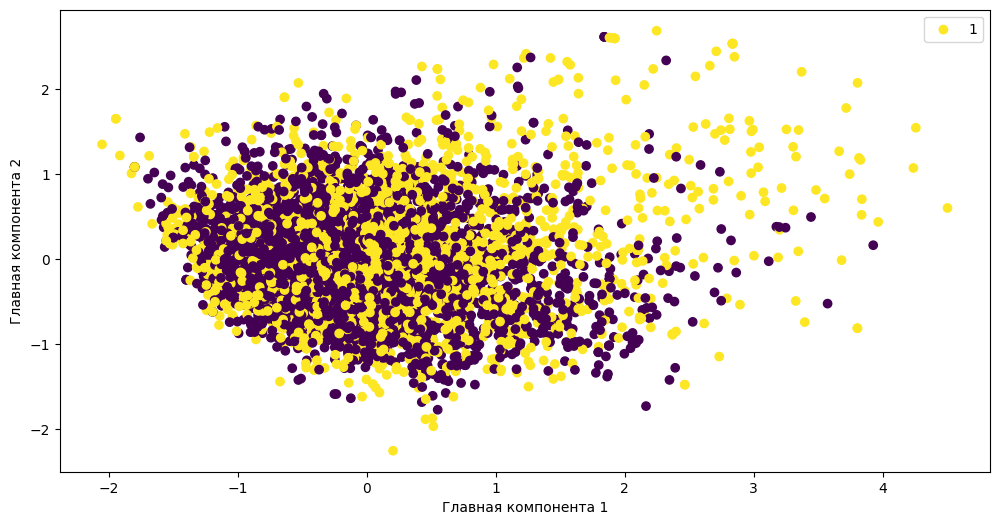

In [65]:
#применим PCA трансформацию  и отобразим наши данные
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_emb)
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.legend(y)
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.show()

## <a id='toc1_2_'></a>[Исследования](#toc0_)

### <a id='toc1_2_1_'></a>[Случайный лес](#toc0_)

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import scikitplot as skplt

n_estimators = range(50,150,10)
depth = range(1,10)
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': n_estimators,  # Number of trees in the forest
    'max_depth' : depth
    
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_jobs = -1)


grid_search = GridSearchCV(rf, param_grid, cv=StratifiedKFold(5), scoring='roc_auc',)
grid_search.fit(X_train, y_train)


y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)

best_param__rf = grid_search.best_params_


f1_score = metrics.f1_score(y_test, y_pred, average='macro')
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Test F1 score:", f1_score)
print("Test accuracy:", accuracy)


Test F1 score: 0.5723593883155005
Test accuracy: 0.6589861751152074


In [68]:
best_param__rf

{'max_depth': 9, 'n_estimators': 120}

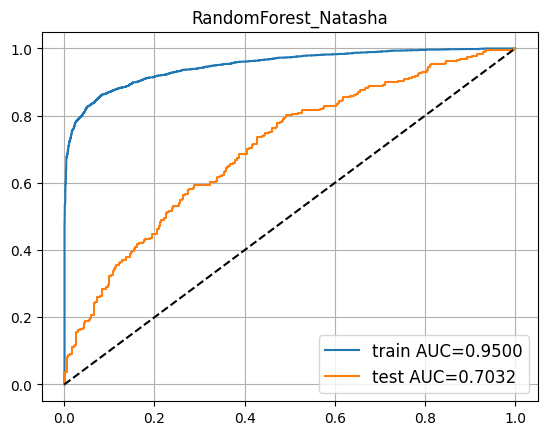

In [69]:
out_dict = {}
out_dict = visualize_and_save_results(grid_search, 'RandomForest_Natasha', X_train, X_test, y_train, y_test, out_dict)


### <a id='toc1_2_2_'></a>[Логистическая регрессия](#toc0_)

C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pac

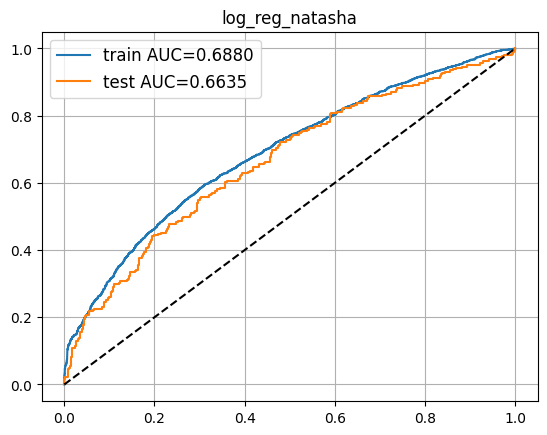

In [72]:
lr = LogisticRegression()



param_grid = {'penalty': ['l1','l2'],
                'solver':['liblinear','saga'],
                #'max_iter': [3, 4, 5],
                'C':[0,1, 0.2, 0.3, 0.4, 0.5]}

gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=2)
gs.fit(X_train, y_train)
best_params_log_reg = gs.best_params_

out_dict = visualize_and_save_results(gs, 'log_reg_natasha', X_train, X_test, y_train, y_test, out_dict)


In [73]:
best_params_log_reg

{'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}

### <a id='toc1_2_3_'></a>[lightgbm](#toc0_)

C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
900 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

[LightGBM] [Info] Number of positive: 2345, number of negative: 3512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 5857, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400376 -> initscore=-0.403900
[LightGBM] [Info] Start training from score -0.403900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

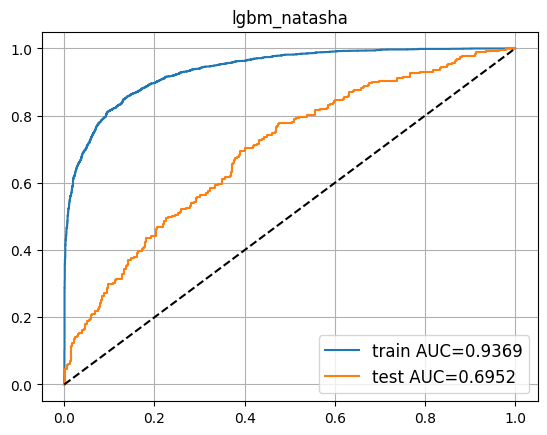

In [74]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


lgbm = LGBMClassifier(objective='binary')

param_grid = {
            'boosting_type':['gbdt','rf'],
            'max_depth': [1,2,3,4,5],
            'num_leaves' : [3,5,10,20],
            'n_estimators' :[30,50,100,150,200,250,300,350,400]
            }

gs = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1,return_train_score=True)

gs.fit(X_train, y_train)



out_dict = visualize_and_save_results(gs, 'lgbm_natasha', X_train, X_test, y_train, y_test, out_dict)


In [78]:
gs.best_params_

{'boosting_type': 'gbdt',
 'max_depth': 4,
 'n_estimators': 100,
 'num_leaves': 20}

### <a id='toc1_2_4_'></a>[Решающие деревья](#toc0_)

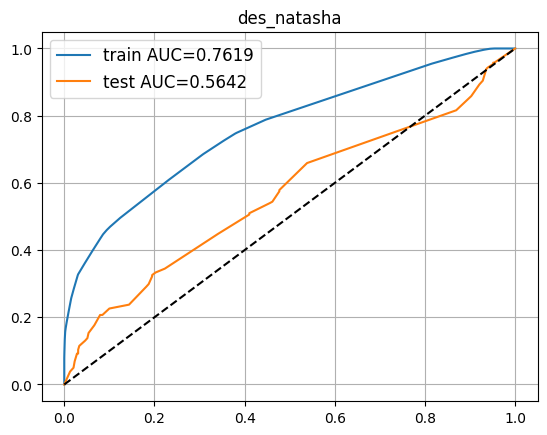

In [81]:
from sklearn.tree import DecisionTreeClassifier

# YOUR CODE HERE

from sklearn.model_selection import GridSearchCV
from sklearn import metrics


param_grid = {
    'max_depth': np.arange(2, 101, 5)
}


decision_tree = DecisionTreeClassifier(random_state=42)


gs = GridSearchCV(decision_tree, param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)



best_param_dec_tree = gs.best_params_




out_dict = visualize_and_save_results(gs, 'des_natasha', X_train, X_test, y_train, y_test, out_dict)

### <a id='toc1_2_5_'></a>[Бэггинг](#toc0_)

C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


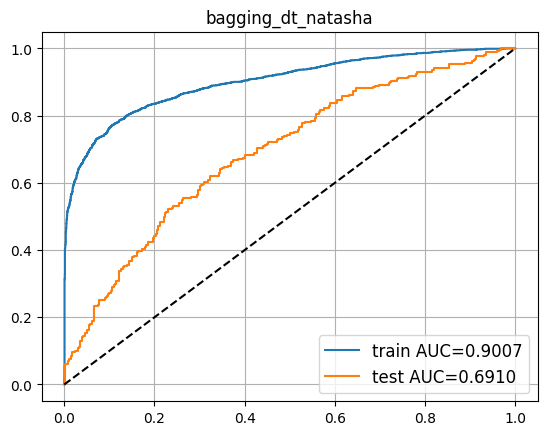

In [82]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier



N = 50 #размер ансамбля
    
decision_tree = DecisionTreeClassifier(**best_param_dec_tree, random_state=42)
bagging_dt = BaggingClassifier(base_estimator=decision_tree, n_estimators=N, random_state=42)
bagging_dt.fit(X_train, y_train)


out_dict = visualize_and_save_results(bagging_dt, 'bagging_dt_natasha', X_train, X_test, y_train, y_test, out_dict)


C:\Users\rvv19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


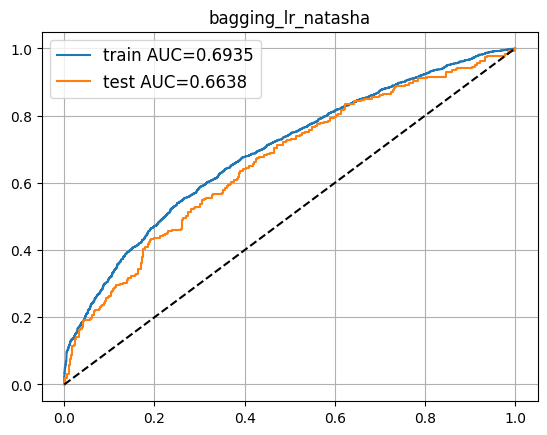

In [83]:
N = 30 #размер ансамбля
    

logistic_regression = LogisticRegression(**best_params_log_reg)
bagging_lr = BaggingClassifier(base_estimator=logistic_regression, n_estimators=N, random_state=42)
bagging_lr.fit(X_train, y_train)



out_dict = visualize_and_save_results(bagging_lr, 'bagging_lr_natasha', X_train, X_test, y_train, y_test, out_dict)


### <a id='toc1_2_6_'></a>[нейронная сеть](#toc0_)

In [84]:
#выберем устройство для обучения
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# перенесем данные на устройство
X_train_emb_torch = torch.tensor(X_train, dtype=torch.float).to(device)
X_test_emb_torch = torch.tensor(X_test, dtype=torch.float).to(device)

y_train_torch = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long).to(device)

In [85]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch) # your code here

        
        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch) # your code here

        # compute gradients
        # your code here
        loss.backward()
        # Adam step
        # your code here
        opt.step()

        # clear gradients
        # your code here
        opt.zero_grad()

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

In [86]:
class Regress(nn.Module):
    def __init__(self, n_input_features):
        super(Regress, self).__init__()
        self.linear1 = nn.Linear(n_input_features, 16)
       # self.linear2 = nn.Linear(32, 16)
       # self.linear3 = nn.Linear(16, 8)
        self.linear4 = nn.Linear(16, 2)
    
    #sigmoid transformation of the input 
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
       # x = self.linear2(x)
       # x = torch.relu(x)
       # x = self.linear3(x)        
      #  x = torch.relu(x)
        x = self.linear4(x)        
        x = torch.sigmoid(x)
        return x


model = Regress(X_train_emb_torch.shape[1]).to(device)

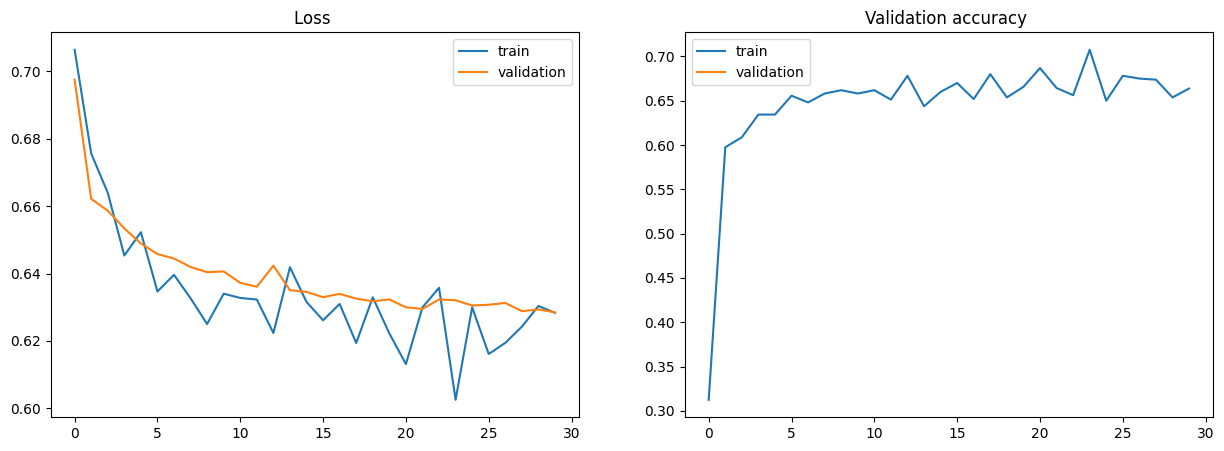

In [87]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model = train_model(model, opt, X_train_emb_torch, y_train_torch, X_test_emb_torch, y_test_torch, n_iterations=1500)

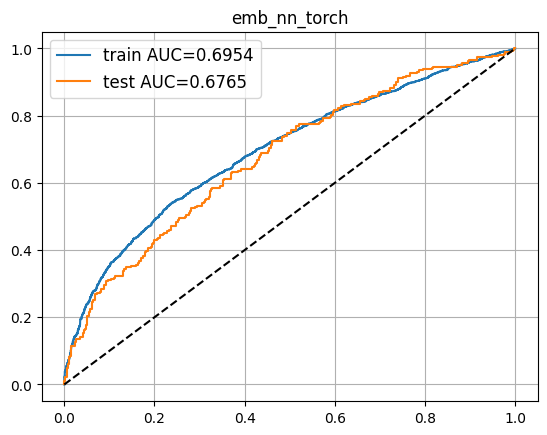

In [88]:
out_dict = visualize_and_save_results(model, 'emb_nn_torch', X_train_emb_torch, X_test_emb_torch, y_train, y_test, out_dict)

## <a id='toc1_3_'></a>[Выводы](#toc0_)

In [89]:
out_dict

{'RandomForest_Natasha_train': 0.949965333598846,
 'RandomForest_Natasha_test': 0.7031731997249239,
 'log_reg_natasha_train': 0.6880232744510446,
 'log_reg_natasha_test': 0.6635327635327636,
 'lgbm_natasha_train': 0.9369126746676639,
 'lgbm_natasha_test': 0.6951665193044503,
 'des_natasha_train': 0.7618581555288964,
 'des_natasha_test': 0.5641909814323607,
 'bagging_dt_natasha_train': 0.9007378297254371,
 'bagging_dt_natasha_test': 0.6909519599174772,
 'bagging_lr_natasha_train': 0.6934754311747479,
 'bagging_lr_natasha_test': 0.6637587189311327,
 'emb_nn_torch_train': 0.6953519702172508,
 'emb_nn_torch_test': 0.6765202868651145}